<a href="https://colab.research.google.com/github/himanshunagapure/Sentiment-Connect/blob/main/Sentiment_Connect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Connect**

In [1]:
import tweepy
import pandas as pd
import re
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
import pickle
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
plt.style.use('fivethirtyeight') 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# **1.Data Gathering**

In [2]:
#Uploading dataset downloaded from kaggle
from google.colab import files
uploaded = files.upload()

Saving NEP_2020_english_tweet.csv to NEP_2020_english_tweet.csv


In [4]:
df = pd.read_csv("NEP_2020_english_tweet.csv")
df.head()

,Unnamed: 0,Author_ID,Date_of_tweet,Tweet,Likes_on_tweet,User_handle,Tweet_link
0,0,60483175,2020-08-04 23:31:59+00:00,Historically #TamilNadu has been a state with ...,1,venkattcv,https://twitter.com/venkattcv/status/129079263...
1,1,1178900491595636736,2020-08-04 23:31:56+00:00,#HelloStrangerEP6 #HarrisonFord #GeorgeFloyd #...,0,BethEYoung3,https://twitter.com/BethEYoung3/status/1290792...
2,2,1072481505090318341,2020-08-04 22:22:30+00:00,@cbseindia29 @PMOIndia @narendramodi @DrRPNish...,1,PatelPrerak18,https://twitter.com/PatelPrerak18/status/12907...
3,3,583518901,2020-08-04 22:20:56+00:00,@PMOIndia’s anti-democratic #NEP2020 was 400+ ...,1,kchongpacrim,https://twitter.com/kchongpacrim/status/129077...
4,4,36339871,2020-08-04 21:01:14+00:00,The latest The Nursing Education Daily! http:/...,0,SkyscapeInc,https://twitter.com/SkyscapeInc/status/1290754...


# **2. Data Preprocessing**

In [5]:
#Removing unwanted columns : Author_ID, User_handle, Tweet_link
df = df.drop(columns=['Unnamed: 0','Author_ID', 'Date_of_tweet', 'User_handle', 'Tweet_link'])
df.head()

,Tweet,Likes_on_tweet
0,Historically #TamilNadu has been a state with ...,1
1,#HelloStrangerEP6 #HarrisonFord #GeorgeFloyd #...,0
2,@cbseindia29 @PMOIndia @narendramodi @DrRPNish...,1
3,@PMOIndia’s anti-democratic #NEP2020 was 400+ ...,1
4,The latest The Nursing Education Daily! http:/...,0


In [6]:
#Lowercasing the Tweets
df['Tweet'] = df['Tweet'].str.lower()

# Removing http links, special characters(@, #, ', +, -, !, comma etc.)
df['Clean_tweet'] = df['Tweet'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ")

#Remove special characters, numbers and punctuations
df['Clean_tweet'] = df['Clean_tweet'].str.replace("[^a-zA-Z#]", " ")

In [7]:
# def cleanText(sentence):
#   sentence = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',' ',sentence)
#   sentence = re.sub(r'[^a-zA-Z#]',' ',sentence)
#   return sentence

# df['Clean_Tweet'] = df['Tweet'].apply(cleanText)

In [8]:
customStopwords = ['i', 'me', 'my', 'we', 'our', 'you','has','ha', 'he', 'him', 'his', 'she', 'her', 'it','the', 'was','what', 'which', 'who', 'whom', 'am', 'is','in', 'are', 'was', 'were', 'be', 'a', 'an','and','of', 'at', 'by', 'for','to','on', 'off','here', 'there', 'when', 'where','all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such','so', 'than','s', 't', 'can','now', 'd', 'l', 'm', 'o', 're', 've', 'y']

In [9]:
#Tokenization 
tokenizedTweet = df['Clean_tweet'].apply(lambda x: x.split())

# Sentence Without Stopwords
sentenceWithoutStopword = tokenizedTweet.apply(lambda sentence: [word for word in sentence if not word in customStopwords])

#Lemmatization
lemmatizer = WordNetLemmatizer()
tokenizedTweet = tokenizedTweet.apply(lambda sentence:[lemmatizer.lemmatize(w) for w in sentence])

#Removing Stopwords
sentenceWithoutStopword = tokenizedTweet.apply(lambda sentence: [word for word in sentence if not word in customStopwords])

#Combining all words into single sentence
for i in range(len(sentenceWithoutStopword)):
  sentenceWithoutStopword[i] = " ".join(sentenceWithoutStopword[i])

df['Clean_Tweet'] = sentenceWithoutStopword

***Creating Columns for -ve and +ve Sentiment Analysis***

In [10]:
#Create function to get subjectivity 
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

#Create function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

#Create 2 new colums
df['Subjectivity'] = df['Clean_tweet'].apply(getSubjectivity)
df['Polarity'] = df['Clean_tweet'].apply(getPolarity)

In [11]:
#Create function for -ve,neutral and +ve analysis
def getAnalysis(score):
  if score<0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysis)

# **3. Data Visualization**

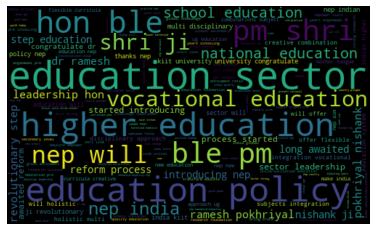

In [12]:
#Visualize frequent words
allWords = " ".join([sentence for sentence in df['Clean_tweet']])

wordCloud = WordCloud(width = 500, height = 300, random_state = 30, max_font_size = 100).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

***Scatter Plot : polarity vs subjectivity***

In [13]:
#Plot polarity vs subjectivity 
# plt.figure(figsize=(8,6))
# for i in range(0, df.shape[0]):
#   plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color='Blue')

# plt.title('Sentiment Analysis')
# plt.xlabel('Polarity')
# plt.ylabel('Subjectivity')
# plt.show()

***Percentage of people***

In [14]:
#Total people count : calculated from likes column
totalLikes = df['Likes_on_tweet'].sum(axis = 0, skipna = True)

#percentage of +ve tweets 
posTweets = df[df.Analysis == 'Positive']
likesCountPos = posTweets['Likes_on_tweet'].sum(axis = 0, skipna = True)
poCount = round((likesCountPos / totalLikes) *100 , 1)

#percentage of -ve tweets 
negTweets = df[df.Analysis == 'Negative']
likesCountNeg = negTweets['Likes_on_tweet'].sum(axis = 0, skipna = True)
negCount = round((likesCountNeg / totalLikes) *100 , 1)

#percentage of neutral tweets 
neutralCount = 100 - (poCount + negCount)

print("positve = ",poCount,"% , Negative = ",negCount,"% , Neutral = ",neutralCount)

positve =  73.1 % , Negative =  7.6 % , Neutral =  19.30000000000001


***Bar plot: Count of +ve, -ve and neutral tweets***

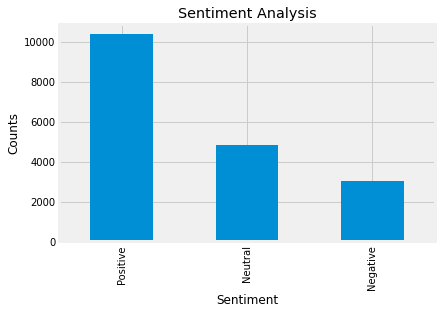

In [15]:
#Show value count
df['Analysis'].value_counts()

#Plotting bar graph of counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind='bar')

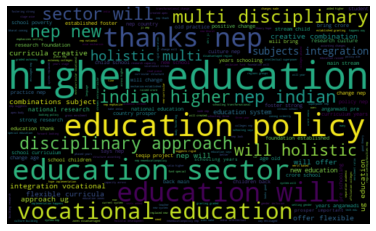

In [16]:
#Visualize frequent -ve words
allWords = " ".join([sentence for sentence in df['Clean_tweet'][df['Analysis']=='Positive']])

wordCloud = WordCloud(width = 500, height = 300, random_state = 30, max_font_size = 100).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

## *Hashtags*

In [17]:
#Extracting hashtags
def hastag_extract(tweets):
  hashtags = []
  #Loop words in tweet
  for tweet in tweets:
    ht = re.findall(r"#(\w+)",tweet)
    hashtags.append(ht)
  return hashtags

In [18]:
#Extract hashtags from +ve tweets
htPos = hastag_extract(df['Tweet'][df['Analysis'] == 'Positive'])

#Extract hashtags from -ve tweets
htNeg = hastag_extract(df['Tweet'][df['Analysis'] == 'Negative'])

#unnest list
htPos = sum(htPos, [])
htNeg = sum(htNeg, [])

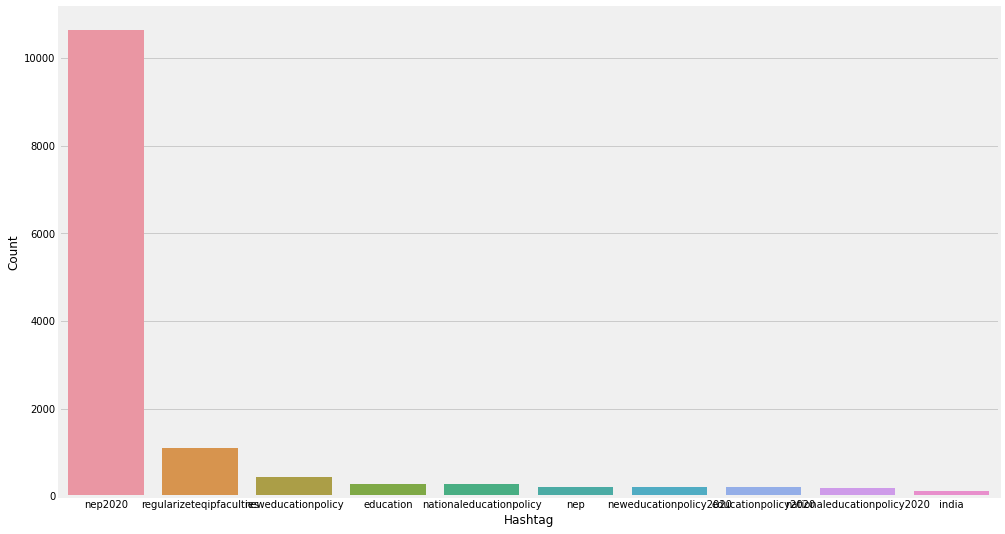

In [19]:
freqPos = nltk.FreqDist(htPos)
dPos = pd.DataFrame({'Hashtag': list(freqPos.keys()), 'Count': list(freqPos.values())})

#Selecting top 10 hashtags
dPos = dPos.nlargest(columns='Count', n=10)
plt.figure(figsize = (15,9))
sns.barplot(data = dPos,x='Hashtag',y='Count')
plt.show()

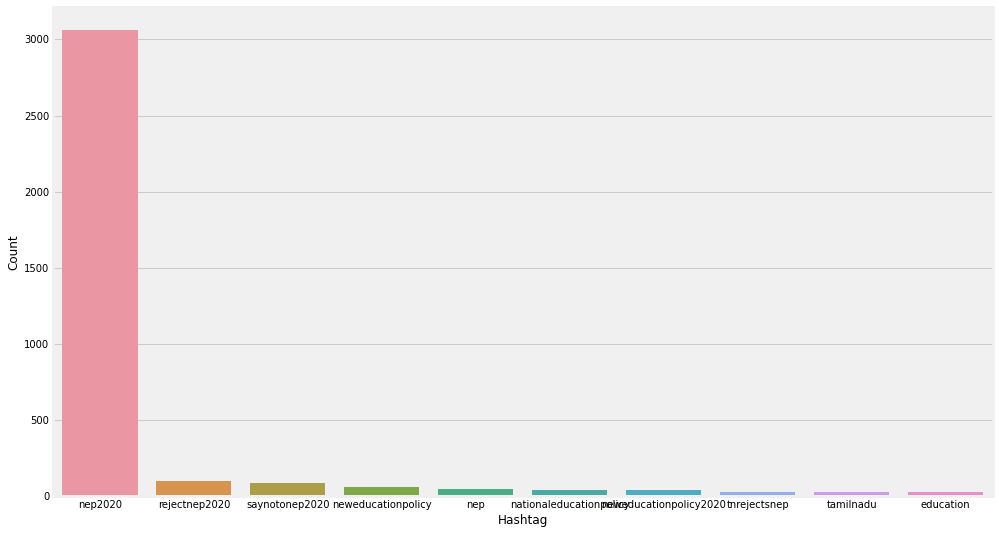

In [20]:
freqNeg = nltk.FreqDist(htNeg)
dNeg = pd.DataFrame({'Hashtag': list(freqNeg.keys()), 'Count': list(freqNeg.values())})

#Selecting top 10 hashtags
dNeg = dNeg.nlargest(columns='Count', n=10)
plt.figure(figsize = (15,9))
sns.barplot(data = dNeg,x='Hashtag',y='Count')
plt.show()

# **4.Feature Extraction**

In [21]:
#Creating new dataframe which only has +ve and -ve values
dfAnalysis = df[df.Analysis != 'Neutral']

In [22]:
bowVectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000)
bow = bowVectorizer.fit_transform(dfAnalysis['Clean_tweet'])

In [23]:
#Creating a new label column : -ve as 1 , +ve as 0 
def getLabel(score):
  if score<0:
    return 1
  else:
    return 0

dfAnalysis['Label'] = dfAnalysis['Polarity'].apply(getLabel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# **5. Model Training and Testing**

In [24]:
xTrain, xTest, yTrain, yTest = train_test_split(bow, dfAnalysis['Label'], random_state=42,test_size=0.25)

## *LogisticRegression*

In [28]:
#Training
model = LogisticRegression(max_iter=123)
model.fit(xTrain, yTrain)

#Testing
yPred = model.predict(xTest)
f1_score(yTest, yPred)

accuracy_score(yTest,yPred)

0.9435483870967742

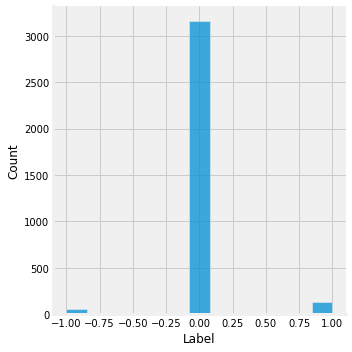

In [30]:
sns.displot(yTest - yPred)
plt.show()

# **Save the model to resue again**

In [33]:
# open a file, where you want to store the data
filename = 'sentimentfile'
outfile = open(filename, 'wb')

# dump information to that file
pickle.dump(model, outfile)
outfile.close()

In [34]:
modelReceieved = open(filename,'rb')
newFile = pickle.load(modelReceieved)

print(newFile)

LogisticRegression(max_iter=123)


In [35]:
print(type(newFile))

<class 'sklearn.linear_model._logistic.LogisticRegression'>


In [41]:
y_prediction = newFile.predict(xTest)
f1_score(yTest, y_prediction)
accuracy_score(yTest,y_prediction)

0.9435483870967742